# Tutorial K-Means

## Principais pontos do tutorial

#### 1. O que é K-Means, para que serve e como podemos utilizá-lo.

#### 2. Problemas relacionados e métricas de comparação.

#### 3. Spectral Clustering

#### 4. K-Means aplicado ao *load_digits()* (subconjunto do MNIST)

Referências:

https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://datasciencemadesimpler.wordpress.com/2016/03/05/why-k-means-is-not-always-a-good-idea/

### Importando as bibliotecas

In [48]:
%matplotlib inline
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Iremos usar o estilo de plots como o *ggplot* (é mais bonito ^.^)

In [2]:
plt.style.use('ggplot')

## 1) O que é K-Means, para que serve e como podemos utilizá-lo.


O algoritmo do K-Means é relativamente simples. 
Dado um número k de clusters inicial (veremos porque isso pode ser um problema) selecionados aleatoriamente, são calculados as distâncias de cada ponto aos k pontos (centros) escolhidos e o ponto recebe a *label* do cluster mais próximo, re-calculamos os centros com base na média do cluster, até que os clusters não mudem.

Alguns problemas ficam evidentes pela construção do algoritmo:
- o número de clusters é dado inicialmente, e nem sempre sabemos o número correto
- o uso da média para re-calcular os centros pode ser problemático se considerarmos outliers
- dependendo da geometria dos clusters, pode ser necessário mapearmos os dados para uma dimensão maior antes de aplicar o K-Means

Para praticarmos, vejamos como ele se comporta com um dataset simples, utilizando a função *make_blobs* do *sklearn*.

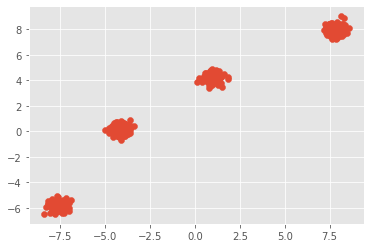

In [3]:
X, y_true = make_blobs(n_samples=500, centers=4, cluster_std=0.3, random_state=3)
plt.scatter(X[:, 0], X[:, 1])

Aplicando o K-Means com 4 clusters:

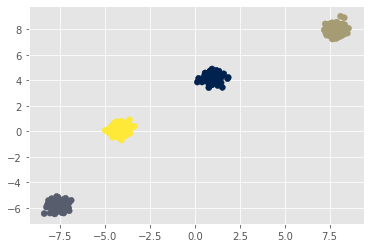

In [4]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_result = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], cmap='cividis', c=y_result)

Vemos que o KMeans conseguiu selecionar bem cada um dos clusters.
Mas é evidente que nesse caso eles estão claramente bem separados, além disso, sabiamos pelo *plot* que seriam necessários 4 clusters.

Podemos *plotar* os dados junto com os centros obtidos pelo algoritmo.

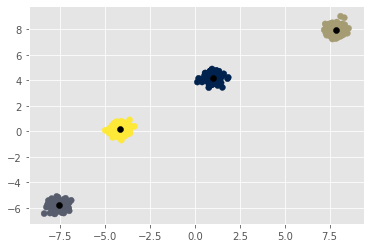

In [5]:
center = kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], cmap='cividis', c=y_result)
plt.scatter(center[:, 0], center[:, 1], cmap='cividis', c='black')

Para fins de teste, iremos analisar um caso com 3 clusters, com os dados $X \sim Normal$ multivariada.
As médias e covariâncias são dadas na célula abaixo.

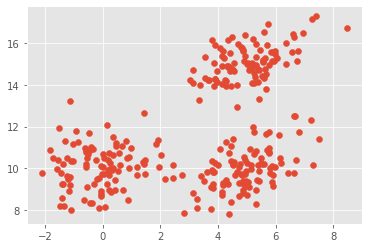

In [6]:
X_1 = np.random.multivariate_normal([0, 10], [[1, 0],[0, 1]], (100,))
X_2 = np.random.multivariate_normal([5, 15], [[1, 0.5],[0.5, 1]], (100,))
X_3 = np.random.multivariate_normal([5, 10], [[1, 0.5],[0.5, 1]], (100,))
X = np.append(np.append(X_1, X_2, axis=0), X_3, axis=0)

plt.scatter(X[:,0], X[:,1])

## 2) Problemas relacionados e métricas de comparação.

Como vimos anteriormente, o número de clusters pode influenciar fortemente nos resultados do K-Means, e ter de escolher esse valor de antemão pode ser problemático. Iremos verificar a diferença entre escolher 3 ou 4 clusters.

In [7]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)
y_result_3 = kmeans_3.predict(X)

kmeans_4 = KMeans(n_clusters=4)
kmeans_4.fit(X)
y_result_4 = kmeans_4.predict(X)

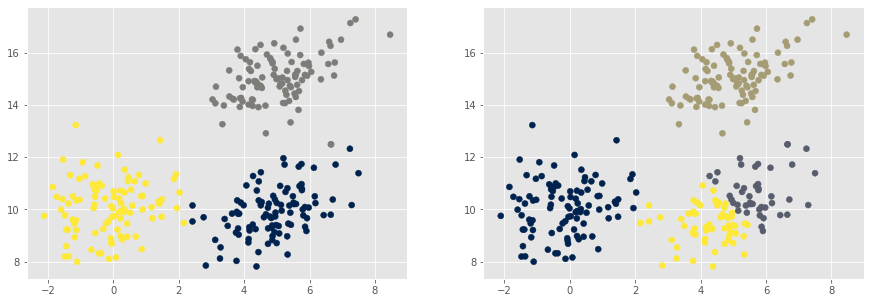

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], cmap='cividis', c=y_result_3)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], cmap='cividis', c=y_result_4)

Vemos que nesse caso, escolher 3 clusters foi razoável (sabiamos que seria o ideal), mas já com 4 clusters, o *label* dos dados do cluster em azul mudou parcialmente para amarelo (sendo que amarelo passou para bege claro).

Uma métrica utilizada para avaliar algoritmos não supervisionados é o Silhouette Score. Seu cálculo é dado por:

$$
SH = \frac{dist. entre clusters - dist. intra cluster}{max(dist. entre clusters, dist. intra cluster)}
$$

Essa medida por ser entendida como uma interpretação da variância presente nos dados. E veremos asseguir, como ela se aplica ao nosso pequeno dataset.

In [9]:
sil_3 = silhouette_score(X, y_result_3)
sil_4 = silhouette_score(X, y_result_4)

In [10]:
print("Silhouette score for 4 clusters: {:.4f} | Silhouette score for 3 clusters: {:.4f}".format(sil_3, sil_4))

Silhouette score for 4 clusters: 0.6417 | Silhouette score for 3 clusters: 0.5363


Podemos testar diferentes k's e verificar dentre eles, qual tem o maior Silhouette score. No nosso caso, 3 clusters é a opção ideal.

Text(0, 0.5, 'Número de clusters')

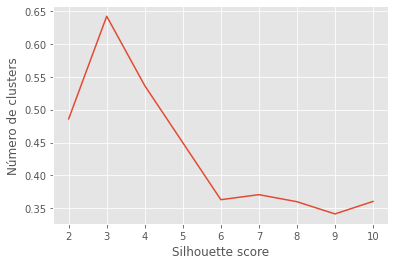

In [11]:
shs = []
x = []
for i in range(2,11):
    kmeans_i = KMeans(n_clusters=i)
    kmeans_i.fit(X)
    y_result_i = kmeans_i.predict(X)
    x.append(i)
    shs.append(silhouette_score(X, y_result_i))
    
plt.plot(x, shs)
plt.xlabel("Silhouette score")
plt.ylabel("Número de clusters")

## 3) Spectral Clustering

Além do problema relacionado ao número de clusters, existem casos nos quais o K-Means não se comporta bem. A seguir, veremos um conjunto cujo formato é bastante irregular, e difere dos clusters que se parecem normais (no sentido estatístico).

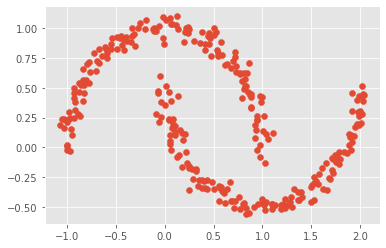

In [12]:
X, y = make_moons(n_samples=300, noise=0.05, random_state=3)
plt.scatter(X[:,0], X[:,1])

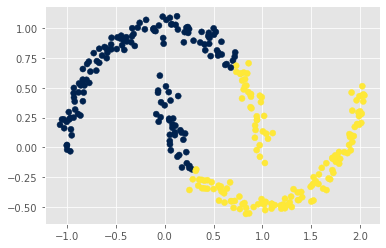

In [13]:
kmeans_moons = KMeans(n_clusters=2, n_init=20)
kmeans_moons.fit(X)
y_result_moons = kmeans_moons.predict(X)
plt.scatter(X[:, 0], X[:, 1], cmap='cividis', c=y_result_moons)

Aqui, podemos ver um caso claro no qual o K-Means falha em reconhecer os dois clusters. Uma alternativa para casos como esse, é utilizar Spectral Clustering, que por baixo dos panos projeta o conjunto de dados em uma dimensão maior, para então aplicar o K-Means, na premissa de encontrar separar os clusters de uma maneira mais precisa que somente aplicando o K-Means.

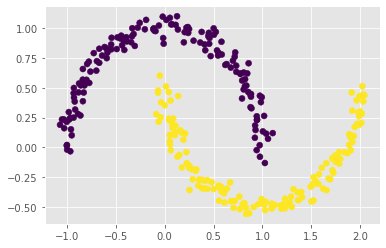

In [14]:
spc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
y_spc = spc.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], cmap='viridis', c=y_spc)

Mas claro, como nada é uma panaceia, mesmo Spectral Clustering falha em certos casos. Portanto, é necessário testar parâmetros, e eventualmente utilizar outro algoritmo de clustering, dado as características dos dados e o que o modelo assume.

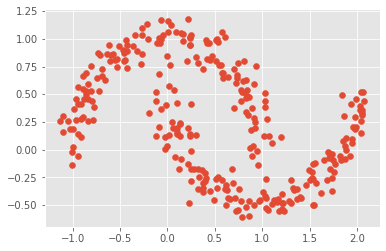

In [15]:
X, y = make_moons(n_samples=300, noise=0.09, random_state=3)
plt.scatter(X[:,0], X[:,1])

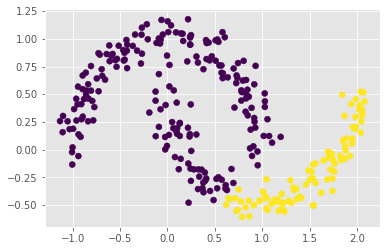

In [16]:
spc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
y_spc = spc.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], cmap='viridis', c=y_spc)

Acima, vemos um caso que mesmo Spectral Clustering não reconhece os 2 clusters da forma desejada.

## 4) K-Means aplicado ao *load_digits()* (subconjunto do MNIST) 

Para uma aplicação mais real e prática, iremos utilizar o dataset do *load_digits()*, que é basicamente o MNIST reduzido, e analisar como o K-Means se comporta na classificação de dígitos por meio de clustering.

Aqui, o número de clusters $n\_clusters=10$, pois temos dígitos no intervalo de 0-9.

In [50]:
digits = load_digits()
kmeans = KMeans(n_clusters=10, random_state=3)
y_result = kmeans.fit_predict(digits.data)

Cada uma das imagens é 8x8, portanto, cada centróide do cluster tem 64 dimensões.

In [51]:
kmeans.cluster_centers_.shape

(10, 64)

Podemos verificar visualmente qual é o centro de cada um dos 10 clusters obtidos

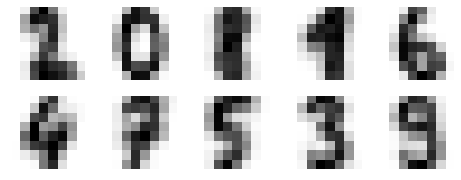

In [52]:
fig, ax = plt.subplots(2,5,figsize=(8,3))
centers = kmeans.cluster_centers_.reshape(10,8,8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Para analisar o caso de classificação, devemos verificar os labels que o K-Means atribuiu as imagens, para posteriormente comparar com o label real.

In [53]:
labels = np.zeros_like(y_result)
for i in range(10):
    mask = (y_result == i)
    labels[mask] = mode(digits.target[mask])[0]

Calculando as métricas para a classificação:

In [54]:
acc = accuracy_score(digits.target, labels)

print("Accuracy score:  {}".format(acc))

Accuracy score:  0.7896494156928213


Podemos observar que o K-Means fez um bom trabalho na previsão dos dígitos, tendo 78% de acurácia. A seguir, podemos verificar a *confusion matrix* correspondente:

Text(51.0, 0.5, 'Label verdadeiro')

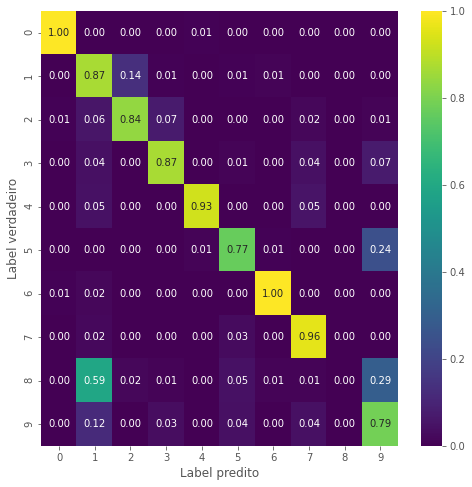

In [55]:
mx = confusion_matrix(digits.target, labels).max()
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(digits.target, labels)/mx, cmap='viridis', annot=True, fmt='.2f')
plt.xlabel("Label predito")
plt.ylabel("Label verdadeiro")

Podemos observar que o K-Means falha mais no reconhecimento do dígito 8, prevendo em seu lugar os dígitos 1 ou 9. Podemos avaliar o desempenho do Spectral Clustering:

In [56]:
spc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', assign_labels='kmeans')
y_result = spc.fit_predict(digits.data)
labels = np.zeros_like(y_result)

for i in range(10):
    mask = (y_result == i)
    labels[mask] = mode(digits.target[mask])[0]
    
acc = accuracy_score(digits.target, labels)

print("Accuracy score:  {}".format(acc))

Accuracy score:  0.8230383973288815


Text(51.0, 0.5, 'Label verdadeiro')

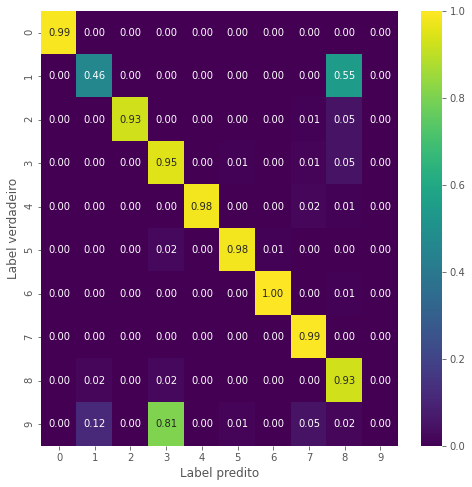

In [57]:
mx = confusion_matrix(digits.target, labels).max()
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(digits.target, labels)/mx, cmap='viridis', annot=True, fmt='.2f')
plt.xlabel("Label predito")
plt.ylabel("Label verdadeiro")

In [58]:
agg = AgglomerativeClustering(n_clusters=10)
y_result = agg.fit_predict(digits.data)
labels = np.zeros_like(y_result)

for i in range(10):
    mask = (y_result == i)
    labels[mask] = mode(digits.target[mask])[0]
    
acc = accuracy_score(digits.target, labels)
print("Accuracy score:  {}".format(acc))

Accuracy score:  0.8619922092376182


Text(51.0, 0.5, 'Label verdadeiro')

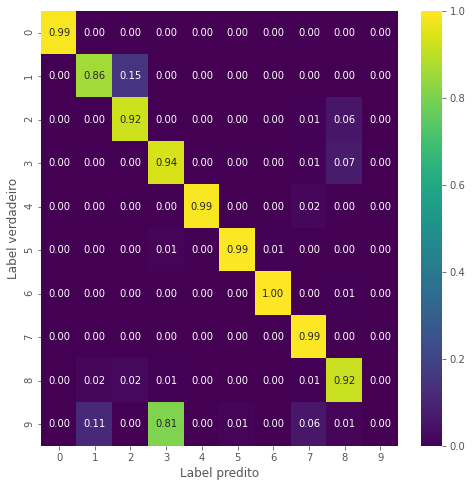

In [59]:
mx = confusion_matrix(digits.target, labels).max()
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(digits.target, labels)/mx, cmap='viridis', annot=True, fmt='.2f')
plt.xlabel("Label predito")
plt.ylabel("Label verdadeiro")

In [61]:
tsne = TSNE(init='pca', random_state=3)
d_proj = tsne.fit_transform(digits.data)
kmeans = KMeans(n_clusters=10, random_state=3)
y_result = kmeans.fit_predict(d_proj)

labels = np.zeros_like(y_result)

for i in range(10):
    mask = (y_result == i)
    labels[mask] = mode(digits.target[mask])[0]
    
acc = accuracy_score(digits.target, labels)
print("Accuracy score:  {}".format(acc))

Accuracy score:  0.9443516972732332


Text(51.0, 0.5, 'Label verdadeiro')

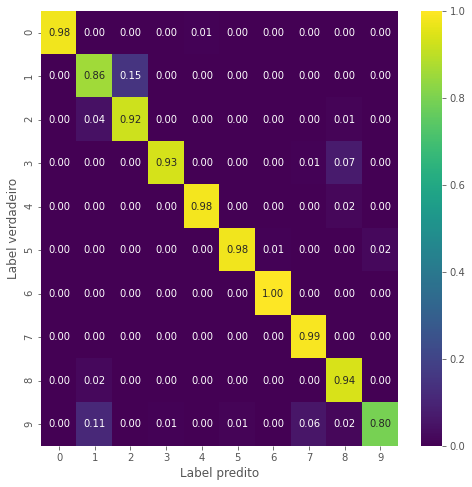

In [62]:
mx = confusion_matrix(digits.target, labels).max()
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(digits.target, labels)/mx, cmap='viridis', annot=True, fmt='.2f')
plt.xlabel("Label predito")
plt.ylabel("Label verdadeiro")